<a href="https://colab.research.google.com/github/albuut/Medical-Malpractice-Analysis/blob/bayesian/CS235_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot

# Medical Malpractice Analysis

# Google Colab Startup
Make sure to clone the repository into the Google Colab.

In [2]:
!git clone https://github.com/albuut/Medical-Malpractice-Analysis.git

Cloning into 'Medical-Malpractice-Analysis'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 364 (delta 89), reused 70 (delta 50), pack-reused 244
Receiving objects: 100% (364/364), 23.62 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (203/203), done.


Run the following code.

In [3]:
%cd /content/Medical-Malpractice-Analysis/
!pip install stepwise-regression
!pip install feature_engine
!pip install factor_analyzer

/content/Medical-Malpractice-Analysis
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 842.1 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 21.3 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.0-py2.py3-none-any.whl size=42487 sha256=b338bb14984603becac510ec43f2f446fdfded27edec1c10eb2224bbc6c54968
  Stored in directory: /root/.cache/pip/wheels/74/a2/6c/26fb1addf1ce6c60a8cef8397f2999f0a1e6e2fcddc8abf33e
Successfully built factor_analyzer


# Data Cleaning

Data manipulated from the original data set.

1. Amount: Log(Amount)

2. Speciality: Dummy variable encoded into different specialities.

3. Insurance: Dummy variable enconded into different insurances.

4. Marital Status: Dummy variable econded into different marital status.

5. Gender: One hot encoded gender for Male = 0 and Female = 1.

The data is also split into three categories.
1. Training: 60%
2. Validation: 20%
3. Testing: 20%

The decison to convert insurance and martial status to become dummy variable encoded was so that we did not have to worry about the numbering of the enumerated variables imply there was a form of ordinality.

Some things to consider for future development is to not remove the unknown's completely from the data set. There could be corrleations where divoriced people do not put their insurance information down. Future reticfication would be to think about how to assign some value to them. Another improvement could be using Stratified Sampling.





## proccess_data.py
```python
import pandas as pd
import numpy as np
import sys

def dummy_variable_col(df, col):
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    df = pd.concat([df,df_temp],axis=1,).reindex(df.index)
    df.drop(col,axis=1,inplace=True)
    return df

## python3 function_name input output log_base
errors = []

if(len(sys.argv) == 4):
    file_input = sys.argv[1]
    file_output = sys.argv[2]
    log_base = sys.argv[3]
else:
    errors.append("Invalid Number of Arguments")

if(len(errors) == 0):
    try:
        df = pd.read_csv(file_input)
    except Exception as e:
        errors.append("Invalid file input / Could not find file")
    
    if(len(errors) == 0):
        #Log the Data
        if log_base == '10':
            df['log_Amount'] = np.log10(df['Amount'])
        elif log_base == '2':
            df['log_Amount'] = np.log2(df['Amount'])
        elif log_base == 'ln':
            df['log_Amount'] = np.log(df['Amount'])
        else:
            errors.append('Invalid 3rd Argument: Use 10, 2, or ln')
        col_move = df.pop('log_Amount')
        df.insert(loc=1,column='log_Amount',value=col_move)
if(len(errors) == 0):
    #Speciality
    df = dummy_variable_col(df,'Specialty')
    #Insurance
    df = df[df['Insurance'].str.contains("Unknown") == False]
    df = dummy_variable_col(df,'Insurance')
    #Marital Status
    df = df[df['Marital Status'] != 4]
    df = dummy_variable_col(df,'Marital Status')
    df = df.rename(columns={0:'Divorced', 1:'Single', 2:'Married', 3:'Widowed'})
    #Gender Binary Encode
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    
    #Shuffle Data and Split
    #Consider checking out stratified splitting
    train, validate, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(.8*len(df))])
    
    train = train.reset_index(drop=True) #60%
    validate = validate.reset_index(drop=True) #20%
    test = test.reset_index(drop=True) #20%
    
    total_data = len(train) + len(validate) + len(test)
    
    train.to_csv(file_output + '_train.csv', index=False)
    print("Successfully written data to: " + file_output + '_train.csv')
    validate.to_csv(file_output + '_validate.csv', index=False)
    print("Successfully written data to: " + file_output + '_validate.csv')
    test.to_csv(file_output + '_test.csv', index =False)
    print("Successfully written data to: " + file_output + '_test.csv')
    
else:
    for e in reversed(errors):
        print(e)
```

We can use the following lines to generate the cleaned up data from csv file with different log values down below.

In [4]:
!python process_data.py medicalmalpractice.csv log10_data 10
!python process_data.py medicalmalpractice.csv log2_data 2
!python process_data.py medicalmalpractice.csv ln_data ln

Successfully written data to: log10_data_train.csv
Successfully written data to: log10_data_validate.csv
Successfully written data to: log10_data_test.csv
Successfully written data to: log2_data_train.csv
Successfully written data to: log2_data_validate.csv
Successfully written data to: log2_data_test.csv
Successfully written data to: ln_data_train.csv
Successfully written data to: ln_data_validate.csv
Successfully written data to: ln_data_test.csv


We then display the origonal data down below.

In [ ]:
df_original = pd.read_csv('medicalmalpractice.csv')
df_original

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female
...,...,...,...,...,...,...,...,...
79205,25305,4,64,1,2,General Surgery,Unknown,Male
79206,43098,3,87,0,4,Orthopedic Surgery,Unknown,Male
79207,35398,3,81,0,4,Anesthesiology,Unknown,Male
79208,154228,9,19,0,4,Dermatology,Unknown,Female


We can then observe how the data is cleaned and seperated into different variables to be used in different forms of regression or analysis.

In [ ]:
df_log10 = pd.read_csv('log10_data_train.csv')
df_log10

,Amount,log_Amount,Severity,Age,Private Attorney,Gender,Anesthesiology,Cardiology,Dermatology,Emergency Medicine,...,Thoracic Surgery,Urological Surgery,Medicare/Medicaid,No Insurance,Private,Workers Compensation,Divorced,Single,Married,Widowed
0,142542,5.153943,4,65,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,110162,5.042032,4,72,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,85764,4.933305,3,28,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,204264,5.310192,3,48,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,172914,5.237830,3,47,1,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29519,103582,5.015284,3,9,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
29520,51143,4.708786,9,34,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
29521,46769,4.669958,2,70,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
29522,48367,4.684549,6,6,1,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


# Bayesian Ridge Regression

Initalize variables and read data.

In [54]:
base_file = 'ln_data'

#Untuned Bayesian Regression
base_regressor = BayesianRidge()
#Untuned Bayesian Regression with Transform
log_base_regressor = BayesianRidge()

#Tuned Bayesian Regression
tuned_regressor = BayesianRidge()
#Tuned Log Bayesian Regression
log_tuned_regressor = BayesianRidge()

#File suffixes
train_suffix = '_train.csv'
validate_suffix = '_validate.csv'
test_suffix = '_test.csv'

#Read Data from File
df_bay_train = pd.read_csv(base_file + train_suffix)
df_bay_validate = pd.read_csv(base_file + validate_suffix)
df_bay_test = pd.read_csv(base_file + test_suffix)

#Testing what happens when removing speciality
#df_bay_train = df_bay_train.drop(columns=df_bay_train.columns[6:26])
#df_bay_validate = df_bay_validate.drop(columns=df_bay_validate.columns[6:26])
#df_bay_test = df_bay_test.drop(columns=df_bay_test.columns[6:26])

#Extract our features and our Y
train_x, train_y, log_train_y = df_bay_train.drop(columns=['Amount','log_Amount']), df_bay_train['Amount'], df_bay_train['log_Amount']

#Seed values for initalized hyperparameters for RandomizedSearchCV
bayesian_param = {
    'alpha_init': np.linspace(1e-10,1e-2,num=100),
    'lambda_init': np.linspace(1e-10,1e-2,num=100),
    'alpha_1': np.linspace(1e-8,1e-2,num=100),
    'alpha_2': np.linspace(1e-8,1e-2,num=100),
    'lambda_1': np.linspace(1e-9,1e-2,num=100),
    'lambda_2':np.linspace(1e-4,1e-2,num=100)
}

Search for the best hyperparameters using RandomizedSearchCV and establishing the models.

In [55]:
#Randomized Search to find the best hyperparameters without transform
tuned_cv = RandomizedSearchCV(tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
tuned_cv.fit(train_x,train_y)
tuned_param = tuned_cv.best_params_

#Randomized Search to find the best hyperparameters with transform
log_tuned_cv = RandomizedSearchCV(log_tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
log_tuned_cv.fit(train_x,log_train_y)
log_tuned_param = log_tuned_cv.best_params_

#Model with hyperparamters
tuned_model = BayesianRidge(alpha_init = tuned_param['alpha_init'], lambda_init = tuned_param['lambda_init'], alpha_1 = tuned_param['alpha_1'], alpha_2 = tuned_param['alpha_2'], lambda_1 = tuned_param['lambda_1'], lambda_2 = tuned_param['lambda_2'])
tuned_model.fit(train_x,train_y)

#Log model with hyperparameters
log_tuned_model = BayesianRidge(alpha_init = log_tuned_param['alpha_init'], lambda_init = log_tuned_param['lambda_init'], alpha_1 = log_tuned_param['alpha_1'], alpha_2 = log_tuned_param['alpha_2'], lambda_1 = log_tuned_param['lambda_1'], lambda_2 = log_tuned_param['lambda_2'])
log_tuned_model.fit(train_x, log_train_y)

#Base Regressors
base_regressor.fit(train_x,train_y)
log_base_regressor.fit(train_x, log_train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


BayesianRidge()

Use our validation data to determine the performance of our different models.

In [56]:
#Extract Data from the Validation data set to train the hyperparameter
validate_x, validate_y, log_validate_y = df_bay_validate.drop(columns=['Amount','log_Amount']), df_bay_validate['Amount'], df_bay_validate['log_Amount']

#Predict off the validaton data
base_bay_predict_validate = base_regressor.predict(validate_x)
log_bay_predict_validate = log_base_regressor.predict(validate_x)
tuned_bay_predict_validate = tuned_model.predict(validate_x)
log_tuned_bay_predict_validate = log_tuned_model.predict(validate_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,base_bay_predict_validate))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_bay_predict_validate))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,tuned_bay_predict_validate))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_tuned_bay_predict_validate))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(validate_y - base_bay_predict_validate))
log_bay_predict_mae = np.mean(np.abs(log_validate_y - log_bay_predict_validate))
tuned_bay_predict_mae = np.mean(np.abs(validate_y - tuned_bay_predict_validate))
log_tuned_bay_predict_mae = np.mean(np.abs(log_validate_y - log_tuned_bay_predict_validate))

#Find Mean
validate_y_mean = np.mean(validate_y)
log_validate_y_mean = np.mean(log_validate_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", np.sqrt(base_bay_predict_rmse))
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(tuned_bay_predict_rmse))

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", np.sqrt(log_bay_predict_rmse))
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(log_tuned_bay_predict_rmse))


print()
print('Base Stat')
t_statistic, p_value = stats.ttest_ind(validate_y, base_bay_predict_validate, equal_var=True)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(validate_y, tuned_bay_predict_validate)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()
print('Log Transform Stat')
t_statistic, p_value = stats.ttest_ind(log_validate_y, log_bay_predict_validate)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(log_validate_y, log_tuned_bay_predict_validate)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 129272.216120899
Base RMSE: 421.0571464896149
Tuned MAE: 129272.21589614364
Tuned RMSE: 421.0571464826446

Log Transform
Base MAE: 0.7117665376796106
Base RMSE: 0.9474883540834719
Tuned MAE: 0.7117662649815452
Tuned RMSE: 0.947488239129307

Base Stat
T Value: 0.618312964304542
P value: 0.5363762125637848
Tuned T Value: 0.6183129659566756
Tuned P value: 0.5363762114749585

Log Transform Stat
T Value: 0.5931510676541275
P value: 0.5530868720657036
Tuned T Value: 0.5931504678895619
Tuned P value: 0.5530872734068684

P value is larger than 0.05, we cannot reject null hypothesis


Lets run an additional prediction on our remaining 20% data that we haven't seen  to make sure our data is not overfitted. This time we are only testing our log tuned since it has a better MAE. However, it should not matter much since the tuned and based are almost indentical.

In [57]:
test_x, test_y, log_test_y = df_bay_test.drop(columns=['Amount','log_Amount']), df_bay_test['Amount'], df_bay_test['log_Amount']
#Predict off the validaton data
base_bay_predict_test = base_regressor.predict(test_x)
log_bay_predict_test = log_base_regressor.predict(test_x)
tuned_bay_predict_test = tuned_model.predict(test_x)
log_tuned_bay_predict_test = log_tuned_model.predict(test_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(test_y,base_bay_predict_test))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_test_y,log_bay_predict_test))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(test_y,tuned_bay_predict_test))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_test_y,log_tuned_bay_predict_test))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(test_y - base_bay_predict_test))
log_bay_predict_mae = np.mean(np.abs(log_test_y - log_bay_predict_test))
tuned_bay_predict_mae = np.mean(np.abs(test_y - tuned_bay_predict_test))
log_tuned_bay_predict_mae = np.mean(np.abs(log_test_y - log_tuned_bay_predict_test))

#Find Mean
test_y_mean = np.mean(test_y)
log_test_y_mean = np.mean(log_test_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", base_bay_predict_rmse)
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", tuned_bay_predict_rmse)

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", log_bay_predict_rmse)
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", log_tuned_bay_predict_rmse)

print()
print('Base Stat')
t_statistic, p_value = stats.ttest_ind(test_y, base_bay_predict_test)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(test_y, tuned_bay_predict_test)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()
print('Log Transform Stat')
t_statistic, p_value = stats.ttest_ind(log_test_y, log_bay_predict_test)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(log_test_y, log_tuned_bay_predict_test)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 129272.216120899
Base RMSE: 177289.12060997705
Tuned MAE: 129272.21589614364
Tuned RMSE: 177289.12060410724

Log Transform
Base MAE: 0.7117665376796106
Base RMSE: 0.8977341811238067
Tuned MAE: 0.7117662649815452
Tuned RMSE: 0.8977339632883549

Base Stat
T Value: 0.618312964304542
P value: 0.5363762125637848
Tuned T Value: 0.6183129659566756
Tuned P value: 0.5363762114749585

Log Transform Stat
T Value: 0.5931510676541275
P value: 0.5530868720657036
Tuned T Value: 0.5931504678895619
Tuned P value: 0.5530872734068684

P value is larger than 0.05, we cannot reject null hypothesis


From the the null hypothesis being rejected, we can see confirm that the means of our predicator and ground trouths are the same making it statistically significant. Observing our RMSE and MAE staying relatively the same the regression is not a bad predictor.

## Scratch Bayesian Regression

In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools

#partial code from ChatGPT
class BayesianLinearRegression:
    def __init__(self, alpha=1, beta=1, noise_variance=1, lambda_reg=1):
        self.alpha = alpha
        self.beta = beta
        self.noise_variance = noise_variance
        self.lambda_reg = lambda_reg
        self.posterior_mean = None
        self.posterior_covariance = None

    def fit(self, X, y):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        n, p = X_data.shape

        #B function
        design_mat = X_data.values

        #Weak Learner Prior
        precision_matrix_prior = np.eye(p) * self.beta
        mean_prior = np.ones(p) * self.alpha

        #L2 Regulraization factor
        regularization_term = self.lambda_reg * np.eye(p)

        #Finding Posterior Precision
        # (1 / self.noise_variance) * design_mat.T @ design_mat = likihood
        # prior term = precision_matrix_prior
        # Regularization_term
        posterior_precision = precision_matrix_prior + (1 / self.noise_variance) * design_mat.T @ design_mat + regularization_term
        # Covariance = Inverse of Posterior Precision
        posterior_covariance = np.linalg.inv(posterior_precision)
        # Weight Function of B
        posterior_mean = posterior_covariance @ (precision_matrix_prior @ mean_prior + (1 / self.noise_variance) * design_mat.T @ y)

        self.posterior_mean = posterior_mean
        self.posterior_covariance = posterior_covariance
        return self

    def predict(self, X):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        design_mat = X_data.values

        #Feature X dotted with Means to generate values
        y_pred_mean = design_mat @ self.posterior_mean

        return y_pred_mean

# Read Data from File
df_train = pd.read_csv('log10_data_train.csv')
df_validate = pd.read_csv('log10_data_validate.csv')

# Split the data into training and validation sets
train_x, train_y, log_train_y = df_train.drop(columns=['Amount','log_Amount']), df_train['Amount'], df_train['log_Amount']
validate_x, validate_y, log_validate_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

# Define hyperparameter values
alpha_values = np.logspace(-4, 0, 5)
beta_values = np.logspace(-4, 0, 5)
noise_variance_values = np.logspace(0, 5, 6)
lambda_reg_values = np.logspace(0, 5, 6)

# Create all combinations of hyperparameters
hyperparameter_combinations = itertools.product(alpha_values, beta_values, noise_variance_values, lambda_reg_values)

best_params = None
best_rmse = float('inf')

# Iterate over hyperparameter combinations
for alpha, beta, noise_variance, lambda_reg in hyperparameter_combinations:
    model = BayesianLinearRegression(alpha=alpha, beta=beta, noise_variance=noise_variance, lambda_reg=lambda_reg)
    model.fit(train_x, log_train_y)
    y_pred = model.predict(validate_x)
    mse = mean_squared_error(log_validate_y, y_pred)
    rmse = np.sqrt(mse)

    print(f'alpha={alpha}, beta={beta}, noise_variance={noise_variance}, lambda_reg={lambda_reg}, RMSE={rmse}')

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'alpha': alpha, 'beta': beta, 'noise_variance': noise_variance, 'lambda_reg': lambda_reg}

print('Best hyperparameters:', best_params)
print(best_rmse)


alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=1.0, RMSE=0.38986566833070896
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=10.0, RMSE=0.38987694016128843
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=100.0, RMSE=0.3927271575620508
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=1000.0, RMSE=0.4917520932400352
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=10000.0, RMSE=0.9365769379974463
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=100000.0, RMSE=1.4458163646987572
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=1.0, RMSE=0.38987694427979275
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=10.0, RMSE=0.39272720633192326
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=100.0, RMSE=0.49175219646160484
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=1000.0, RMSE=0.9365769599910716
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=10000.0, RMSE=1.445816366532868
alpha=0.0

In [53]:
base_model = BayesianLinearRegression()
tuned_model = BayesianLinearRegression(alpha = best_params['alpha'], beta = best_params['beta'], noise_variance = best_params['noise_variance'], lambda_reg = best_params['lambda_reg'])

base_model.fit(X_train, y_train)
tuned_model.fit(X_train, y_train)

df_test = pd.read_csv('log10_data_test.csv')
test_x, test_y, log_test_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

base_predict = base_model.predict(test_x)
tuned_predict = tuned_model.predict(test_x)

base_mse = mean_squared_error(log_validate_y.values, base_predict)
base_rmse = np.sqrt(base_mse)
tuned_mse = mean_squared_error(log_validate_y.values, tuned_predict)
tuned_rmse = np.sqrt(tuned_mse)

base_mae = np.mean(np.abs(log_test_y - base_predict))
tuned_mae = np.mean(np.abs(log_test_y - tuned_predict))

print("Base RMSE:", base_rmse)
print("Tuned RMSE:", tuned_rmse)
print("Base MAE:", base_mae)
print("Tuned MAE:", tuned_mae)

print()

t_statistic, p_value = stats.ttest_ind(log_test_y, base_predict)

print('Base T Value:', t_statistic)
print('Base P value:', p_value)

t_statistic, p_value = stats.ttest_ind(log_test_y, tuned_predict)

print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)

Base RMSE: 0.38995882469439497
Tuned RMSE: 0.3899545905704418
Base MAE: 0.3091663205259694
Tuned MAE: 0.3091870556646483

Base T Value: 0.7279561546502551
Base P value: 0.4666490863452577
Tuned T Value: 0.7494731763378439
Tuned P value: 0.45358101762898806


## Generating Different Mixtures of Data

In [72]:
import pandas as pd
import numpy as np
import sys

def dummy_variable_col(df, col):
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    df = pd.concat([df,df_temp],axis=1,).reindex(df.index)
    df.drop(col,axis=1,inplace=True)
    return df

## python3 function_name input output log_base
errors = []

for i in range(5):
  if(len(errors) == 0):
      file_input = "medicalmalpractice.csv"
      file_output = "data_" + str(i)
      log_base = "10"
      try:
          df = pd.read_csv(file_input)
      except Exception as e:
          errors.append("Invalid file input / Could not find file")

      if(len(errors) == 0):
          #Log the Data
          if log_base == '10':
              df['log_Amount'] = np.log10(df['Amount'])
          elif log_base == '2':
              df['log_Amount'] = np.log2(df['Amount'])
          elif log_base == 'ln':
              df['log_Amount'] = np.log(df['Amount'])
          else:
              errors.append('Invalid 3rd Argument: Use 10, 2, or ln')
          col_move = df.pop('log_Amount')
          df.insert(loc=1,column='log_Amount',value=col_move)
  if(len(errors) == 0):
      np.random.seed(42+i*3)
      #Speciality
      df = dummy_variable_col(df,'Specialty')
      #Insurance
      df = df[df['Insurance'].str.contains("Unknown") == False]
      df = dummy_variable_col(df,'Insurance')
      #Marital Status
      df = df[df['Marital Status'] != 4]
      df = dummy_variable_col(df,'Marital Status')
      df = df.rename(columns={0:'Divorced', 1:'Single', 2:'Married', 3:'Widowed'})
      #Gender Binary Encode
      df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

      #Shuffle Data and Split
      #Consider checking out stratified splitting
      train, validate, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(.8*len(df))])

      train = train.reset_index(drop=True) #60%
      validate = validate.reset_index(drop=True) #20%
      test = test.reset_index(drop=True) #20%

      total_data = len(train) + len(validate) + len(test)

      train.to_csv(file_output + '_train.csv', index=False)
      print("Successfully written data to: " + file_output + '_train.csv')
      validate.to_csv(file_output + '_validate.csv', index=False)
      print("Successfully written data to: " + file_output + '_validate.csv')
      test.to_csv(file_output + '_test.csv', index =False)
      print("Successfully written data to: " + file_output + '_test.csv')

  else:
      for e in reversed(errors):
          print(e)

Successfully written data to: data_0_train.csv
Successfully written data to: data_0_validate.csv
Successfully written data to: data_0_test.csv
Successfully written data to: data_1_train.csv
Successfully written data to: data_1_validate.csv
Successfully written data to: data_1_test.csv
Successfully written data to: data_2_train.csv
Successfully written data to: data_2_validate.csv
Successfully written data to: data_2_test.csv
Successfully written data to: data_3_train.csv
Successfully written data to: data_3_validate.csv
Successfully written data to: data_3_test.csv
Successfully written data to: data_4_train.csv
Successfully written data to: data_4_validate.csv
Successfully written data to: data_4_test.csv


## Testing Different Mixtures of Data

In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools

class BayesianLinearRegression:
    def __init__(self, alpha=1, beta=1, noise_variance=1, lambda_reg=1):
        self.alpha = alpha
        self.beta = beta
        self.noise_variance = noise_variance
        self.lambda_reg = lambda_reg
        self.posterior_mean = None
        self.posterior_covariance = None

    def fit(self, X, y):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        n, p = X_data.shape

        design_mat = X_data.values
        precision_matrix_prior = np.eye(p) * self.beta
        mean_prior = np.ones(p) * self.alpha
        regularization_term = self.lambda_reg * np.eye(p)

        posterior_precision = precision_matrix_prior + (1 / self.noise_variance) * design_mat.T @ design_mat + regularization_term
        posterior_covariance = np.linalg.inv(posterior_precision)
        posterior_mean = posterior_covariance @ (precision_matrix_prior @ mean_prior + (1 / self.noise_variance) * design_mat.T @ y)

        self.posterior_mean = posterior_mean
        self.posterior_covariance = posterior_covariance
        return self

    def predict(self, X):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        design_mat = X_data.values
        y_pred_mean = design_mat @ self.posterior_mean

        return y_pred_mean

for i in range(5):
  # Read Data from File
  df_train = pd.read_csv('data_' + str(i) + '_train.csv')
  df_validate = pd.read_csv('data_' + str(i) + '_validate.csv')

  # Split the data into training and validation sets
  train_x, train_y, log_train_y = df_train.drop(columns=['Amount','log_Amount']), df_train['Amount'], df_train['log_Amount']
  validate_x, validate_y, log_validate_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

  # Define hyperparameter values
  alpha_values = np.logspace(-4, 0, 5)
  beta_values = np.logspace(-4, 0, 5)
  noise_variance_values = np.logspace(0, 5, 6)
  lambda_reg_values = np.logspace(0, 5, 6)

  # Create all combinations of hyperparameters
  hyperparameter_combinations = itertools.product(alpha_values, beta_values, noise_variance_values, lambda_reg_values)

  best_params = None
  best_rmse = float('inf')

  # Iterate over hyperparameter combinations
  for alpha, beta, noise_variance, lambda_reg in hyperparameter_combinations:
      model = BayesianLinearRegression(alpha=alpha, beta=beta, noise_variance=noise_variance, lambda_reg=lambda_reg)
      model.fit(train_x, log_train_y)
      y_pred = model.predict(validate_x)
      mse = mean_squared_error(log_validate_y, y_pred)
      rmse = np.sqrt(mse)

      #print(f'alpha={alpha}, beta={beta}, noise_variance={noise_variance}, lambda_reg={lambda_reg}, RMSE={rmse}')

      if rmse < best_rmse:
          best_rmse = rmse
          best_params = {'alpha': alpha, 'beta': beta, 'noise_variance': noise_variance, 'lambda_reg': lambda_reg}
  print(i)
  print('Best hyperparameters:', best_params)

  base_model = BayesianLinearRegression()
  tuned_model = BayesianLinearRegression(alpha = best_params['alpha'], beta = best_params['beta'], noise_variance = best_params['noise_variance'], lambda_reg = best_params['lambda_reg'])

  base_model.fit(X_train, y_train)
  tuned_model.fit(X_train, y_train)

  df_test = pd.read_csv('data_' + str(i) + '_test.csv')
  test_x, test_y, log_test_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

  base_predict = base_model.predict(test_x)
  tuned_predict = tuned_model.predict(test_x)

  base_mse = mean_squared_error(log_validate_y.values, base_predict)
  base_rmse = np.sqrt(base_mse)
  tuned_mse = mean_squared_error(log_validate_y.values, tuned_predict)
  tuned_rmse = np.sqrt(tuned_mse)

  base_mae = np.mean(np.abs(log_test_y - base_predict))
  tuned_mae = np.mean(np.abs(log_test_y - tuned_predict))

  print("Base RMSE:", base_rmse)
  print("Tuned RMSE:", tuned_rmse)
  print("Base MAE:", base_mae)
  print("Tuned MAE:", tuned_mae)

  print()

  t_statistic, p_value = stats.ttest_ind(log_test_y, base_predict)

  print('Base T Value:', t_statistic)
  print('Base P value:', p_value)

  t_statistic, p_value = stats.ttest_ind(log_test_y, tuned_predict)

  print('Tuned T Value:', t_statistic)
  print('Tuned P value:', p_value)
  print()

0
Best hyperparameters: {'alpha': 1.0, 'beta': 0.0001, 'noise_variance': 1.0, 'lambda_reg': 1.0}
Base RMSE: 0.389514683736443
Tuned RMSE: 0.38951205917230763
Base MAE: 0.30915659277245094
Tuned MAE: 0.30914718597634566

Base T Value: 1.303846419740506
Base P value: 0.19230120250269683
Tuned T Value: 1.2998513961865252
Tuned P value: 0.19366713046134937

1
Best hyperparameters: {'alpha': 1.0, 'beta': 1.0, 'noise_variance': 10.0, 'lambda_reg': 1.0}
Base RMSE: 0.38785866694353577
Tuned RMSE: 0.387880038299446
Base MAE: 0.3081807161547258
Tuned MAE: 0.30850265207746214

Base T Value: 0.20578289792469004
Base P value: 0.8369626292975985
Tuned T Value: 0.47657100165070776
Tuned P value: 0.6336729279523949

2
Best hyperparameters: {'alpha': 0.0001, 'beta': 1.0, 'noise_variance': 1.0, 'lambda_reg': 1.0}
Base RMSE: 0.38630382798378565
Tuned RMSE: 0.38630028734522914
Base MAE: 0.3058033930489782
Tuned MAE: 0.30581942129170764

Base T Value: 0.661995109254235
Base P value: 0.5079821073708565
Tune

# Decision Tree Regression

Set up the training, testing, and validation datasets

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log10_X_train = pd.read_csv('log10_data_train.csv')
log10_X_validate = pd.read_csv('log10_data_validate.csv')
log10_X_test = pd.read_csv('log10_data_test.csv')
log10_Y_train = log10_X_train['Amount']
log10_Y_validate = log10_X_validate['Amount']
log10_Y_test = log10_X_test['Amount']

Create and train the models (parameters have been tested separately)

In [ ]:
#log10_model = DecisionTreeRegressor()
log10_model = DecisionTreeRegressor(max_depth = 3, random_state=1)
log10_model_proposed = DecisionTreeRegressor(criterion= "poisson", max_depth = 3, random_state=1)

log10_model.fit(log10_X_train, log10_Y_train)
log10_model_proposed.fit(log10_X_train, log10_Y_train)

DecisionTreeRegressor(criterion='poisson', max_depth=3, random_state=1)

Predict for validation set and calculate metrics

In [ ]:
log10_pred = log10_model.predict(log10_X_validate)
log10_pred_proposed = log10_model_proposed.predict(log10_X_validate)

log10_Y_validate_arr = log10_Y_validate.to_numpy()

log10_rmse = np.sqrt(mean_squared_error(log10_Y_validate, log10_pred))
log10_mae = mean_absolute_error(log10_Y_validate, log10_pred)

log10_rmse_proposed = np.sqrt(mean_squared_error(log10_Y_validate, log10_pred_proposed))
log10_mae_proposed = mean_absolute_error(log10_Y_validate, log10_pred_proposed)



log10_t_statistic, log10_p_value = ttest_ind(log10_Y_validate_arr, log10_pred)
log10_t_statistic_proposed, log10_p_value_proposed = ttest_ind(log10_Y_validate_arr, log10_pred_proposed)


print(log10_rmse)
print(log10_mae)
print(log10_t_statistic)
print(log10_p_value)

print(log10_rmse_proposed)
print(log10_mae_proposed)
print(log10_t_statistic_proposed)
print(log10_p_value_proposed)

24075.14262742689
18863.825056123154
0.09505876771175681
0.9242691160249246
24496.321377416247
17428.332965092446
0.04812436425378703
0.9616176171183759


Optionally display the generated tree

[Text(0.5, 0.875, 'x[1] <= 5.428\npoisson = 91377.413\nsamples = 29524\nvalue = 186926.423'),
 Text(0.25, 0.625, 'x[1] <= 4.906\npoisson = 15884.733\nsamples = 23910\nvalue = 94291.358'),
 Text(0.125, 0.375, 'x[1] <= 4.592\npoisson = 5451.742\nsamples = 10425\nvalue = 44050.883'),
 Text(0.0625, 0.125, 'poisson = 2428.958\nsamples = 4505\nvalue = 24140.433'),
 Text(0.1875, 0.125, 'poisson = 1299.888\nsamples = 5920\nvalue = 59202.333'),
 Text(0.375, 0.375, 'x[1] <= 5.116\npoisson = 3944.387\nsamples = 13485\nvalue = 133131.324'),
 Text(0.3125, 0.125, 'poisson = 1005.558\nsamples = 6589\nvalue = 105601.794'),
 Text(0.4375, 0.125, 'poisson = 1380.571\nsamples = 6896\nvalue = 159435.278'),
 Text(0.75, 0.625, 'x[0] <= 560781.0\npoisson = 27862.386\nsamples = 5614\nvalue = 581458.736'),
 Text(0.625, 0.375, 'x[1] <= 5.616\npoisson = 8086.192\nsamples = 2684\nvalue = 421399.94'),
 Text(0.5625, 0.125, 'poisson = 2335.618\nsamples = 1255\nvalue = 345888.725'),
 Text(0.6875, 0.125, 'poisson = 184

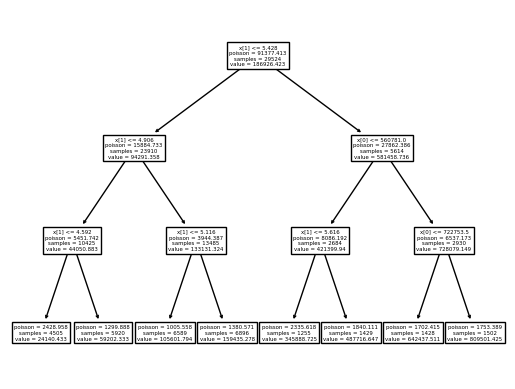

In [ ]:
plot_tree(log10_model_proposed)

# Stepwise Regression

Import necessary libraries and read in preprocessed data files.

In [ ]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
from stepwise_regression import step_reg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv("log10_data_train.csv")
df_validate = pd.read_csv("log10_data_validate.csv")
df_test = pd.read_csv("log10_data_test.csv")

We consider all features except for 'Amount' and 'log_Amount', then set 'log_Amount' to be the target variable. We will see which features significantly impact 'log_Amount the most'

In [ ]:
# consider all features (independent variables) except for 'Amount' and 'log_Amount'
X = df.drop(['log_Amount', 'Amount'], axis=1)

# 'log_Amount' is the dependent variable here
# the goal is to see which independent variables signficantly impact the dependent variable
y = df['log_Amount']

# add a constant to intercept X
X = sm.add_constant(X)

Create a basic linear regression model using our variables. Compute the RMSE and MAE of the baseline model predictions.

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     397.6
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        07:51:22   Log-Likelihood:                -14103.
No. Observations:               29524   AIC:                         2.827e+04
Df Residuals:                   29494   BIC:                         2.852e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

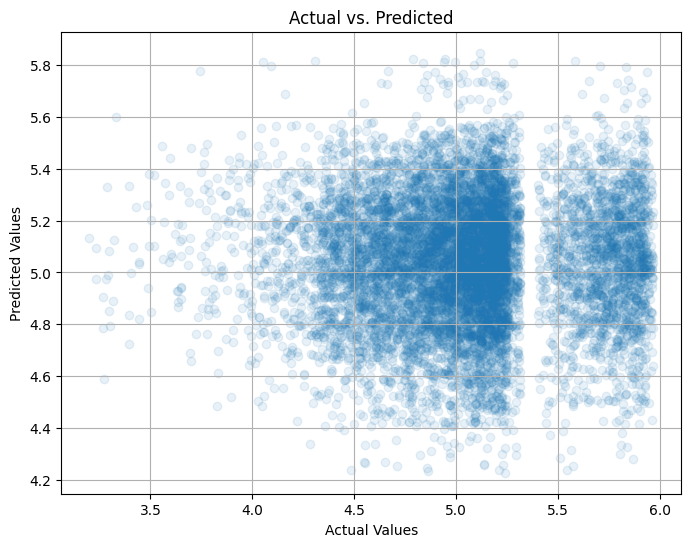

Baseline selection RMSE: 0.5217391786107498
Baseline selection MAE: 0.408135518606285


In [ ]:
model = sm.OLS(y, X)
fit_model = model.fit()
# predict using all independent variables as features
baseline_predict = fit_model.predict(X)
df_test_y = df_test['log_Amount']
baseline_predict = baseline_predict[:len(df_test_y)]
# compute rmse and msa of baseline model predictions
baseline_mse = mean_squared_error(df_test_y, baseline_predict)
baseline_mae = mean_absolute_error(df_test_y, baseline_predict)
# displays the results of the model
print(fit_model.summary())

# plot of the regression
plt.figure(figsize=(8, 6))
plt.scatter(df_test_y, baseline_predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

print("Baseline selection RMSE:", np.sqrt(baseline_mse))
print("Baseline selection MAE:", baseline_mae)

Use the step-reg library to perform backward selection on the features. Backselect will store a list of selected feature names sorted by significance to 'log_Amount' (highest to lowest).

In [ ]:
backselect = step_reg.backward_regression(X, y, 0.05, verbose=False)
print(backselect)

['const', 'Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Plastic Surgeon', 'Radiology', 'Resident', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']


Create a new model using our new feature set from backward selection and test it on our test data. Outputted are results of the regression and statistics.

In [ ]:
X_backselect = X[backselect]
back_model = sm.OLS(y, X_backselect)
fit_back_model = back_model.fit()
# display the results of the model
print(fit_back_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     427.0
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        07:51:27   Log-Likelihood:                -14104.
No. Observations:               29524   AIC:                         2.826e+04
Df Residuals:                   29496   BIC:                         2.850e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

Compute the root mean squared error and mean absolute error of the predictions on the test data.

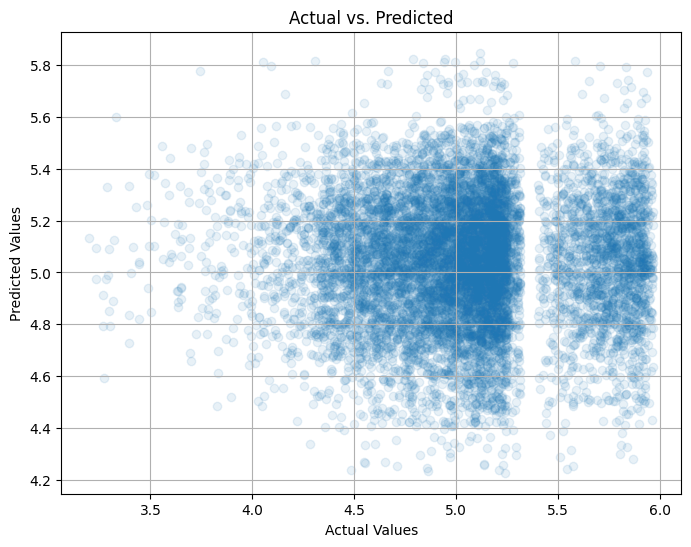

Backward selection RMSE: 0.5217251169557974
Backward selection MAE: 0.4081243118129914


In [ ]:
# make predictions using the new model with selected features from backward selection
b_y_predict = fit_back_model.predict(X_backselect)

# use the testing set
df_test_y = df_test['log_Amount']
b_y_predict = b_y_predict[:len(df_test_y)]

# calculate the root mean squared error and mean absolute error of the  predictions compared to the actual values
b_mse = mean_squared_error(df_test_y, b_y_predict)
b_mae = mean_absolute_error(df_test_y, b_y_predict)
# b_mse = mean_squared_error(y, b_y_predict)
# b_mae = mean_absolute_error(y, b_y_predict)

# plot the regression
plt.figure(figsize=(8, 6))
plt.scatter(df_test_y, b_y_predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

print("Backward selection RMSE:", np.sqrt(b_mse))
print("Backward selection MAE:", b_mae)

Do the same process using the stepwise_regression library, except this time we will select our features using feature selection. In this case, forwardSelect will store a list of selected feature names sorted by significance to 'log_Amount' (highest to lowest).

In [ ]:
forwardselect = step_reg.forward_regression(X, y, 0.05, verbose=False)
# print(forwardselect)

# now create a new model with the forward selected features
# ensure that predictors are significant (i.e p-value >0.05)
X_forwardselect = X[forwardselect]
forward_model = sm.OLS(y, X_forwardselect)
fit_forward_model = forward_model.fit()
# display the results of the model
print(fit_forward_model.summary())

/usr/local/lib/python3.10/dist-packages/stepwise_regression/step_reg.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/usr/local/lib/python3.10/dist-packages/stepwise_regression/step_reg.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/usr/local/lib/python3.10/dist-packages/stepwise_regression/step_reg.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/usr/local/lib/python3.10/dist-packages/stepwise_regression/step_reg.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fut

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     480.3
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        07:51:51   Log-Likelihood:                -14105.
No. Observations:               29524   AIC:                         2.826e+04
Df Residuals:                   29499   BIC:                         2.847e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

Compute the root mean squared error and mean absolute error of the predictions on the test data.

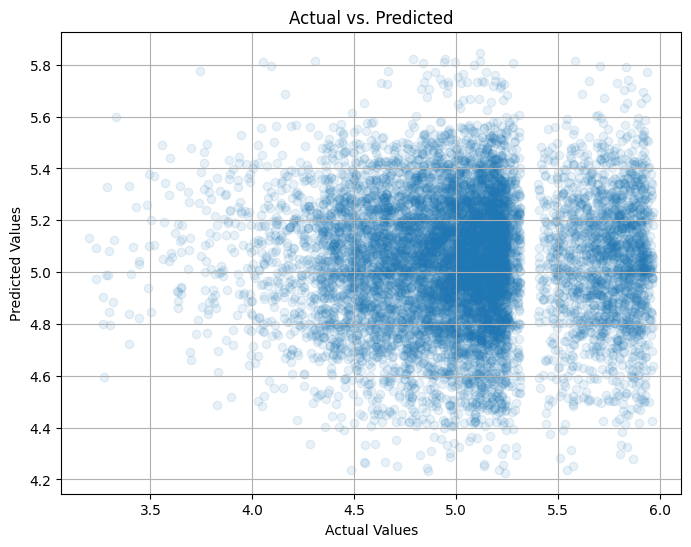

Forward selection RMSE: 0.5217530337363687
Forward selection MAE: 0.40812772898418015


In [ ]:
# make predictions using the new model with selected features from forward selection
f_y_predict = fit_forward_model.predict(X_forwardselect)
f_y_predict = f_y_predict[:len(df_test_y)]
# calculate the root mean squared error and mean absolute error of the predictions compared to the actual values
f_mse = mean_squared_error(df_test_y, f_y_predict)
f_mae = mean_absolute_error(df_test_y, f_y_predict)
# f_mse = mean_absolute_error(y, f_y_predict)
# f_mse = mean_squared_error(y, f_y_predict)

# plot the regression
plt.figure(figsize=(8, 6))
plt.scatter(df_test_y, f_y_predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

print("Forward selection RMSE:", np.sqrt(f_mse))
print("Forward selection MAE:", f_mae)

# Lasso Regression

Import necessary libraries

In [ ]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
from sklearn.preprocessing import PolynomialFeatures
from feature_engine.outliers import OutlierTrimmer

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.model_selection import cross_val_predict


Read in Data

In [ ]:
# file_input = sys.argv[1]

# df = pd.read_csv(file_input)

# train_suffix = '_train.csv'
# validate_suffix = '_validate.csv'
# test_suffix = '_test.csv'

df_train = pd.read_csv('log10_data_train.csv')
df_validate = pd.read_csv('log10_data_validate.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
y_test = df_test['log_Amount']

Default Lasso Regression:

Cross-Validation Results:
Mean Absolute Error (CV): 0.3099368682811276
Mean Squared Error (CV): 0.1525763734491082
2 Most Important Features:
Private Attorney: 0.11397039882104726
Severity: 0.07949332751919898


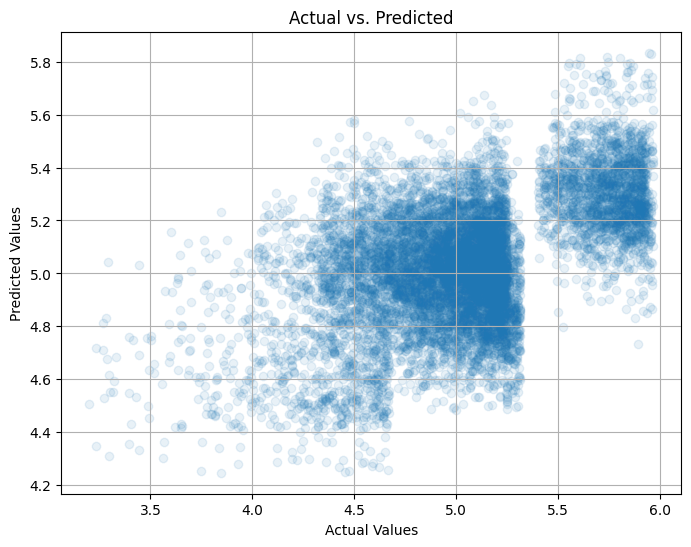

Test Results:
Mean Absolute Error (Test): 0.3091388840164066
Mean Squared Error (Test): 0.15207595546268274


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.001)

y_pred_cv = cross_val_predict(lasso, X_train_scaled, y_train, cv=10)

mae_cv = mean_absolute_error(y_train, y_pred_cv)
mse_cv = mean_squared_error(y_train, y_pred_cv)

print("Cross-Validation Results:")
print(f"Mean Absolute Error (CV): {mae_cv}")
print(f"Mean Squared Error (CV): {mse_cv}")

lasso.fit(X_train_scaled, y_train)

coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")

y_pred = lasso.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

Feature Implementation 1: Spline Transformer

2 Most Important Features:
Severity: 0.09156177088803392
Private Attorney: 0.07080472917934488


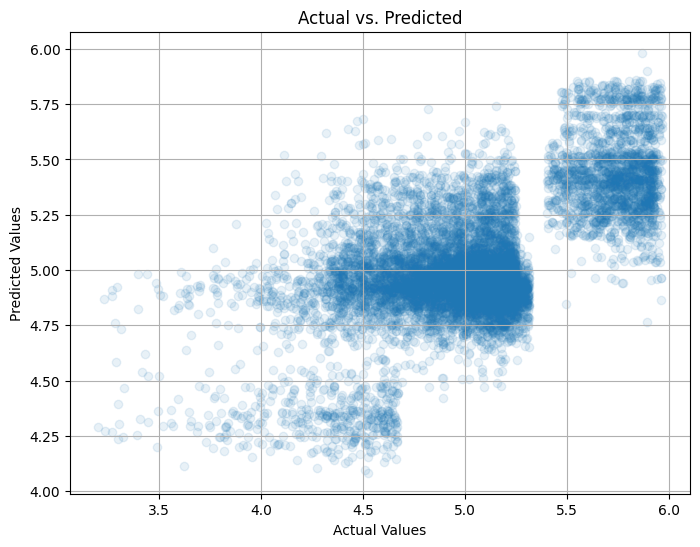

Mean Absolute Error: 0.28048675551870017
Mean Squared Error: 0.12605765375351996


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']

X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

spline_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = spline_transformer.fit_transform(X_train_scaled)
X_test_poly = spline_transformer.transform(X_test_scaled)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_poly, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_poly)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Feature Implementation 2: PCA

PCA:
2 Most Important Features:
Age: -0.13277637890073385
Severity: -0.035494583114948255


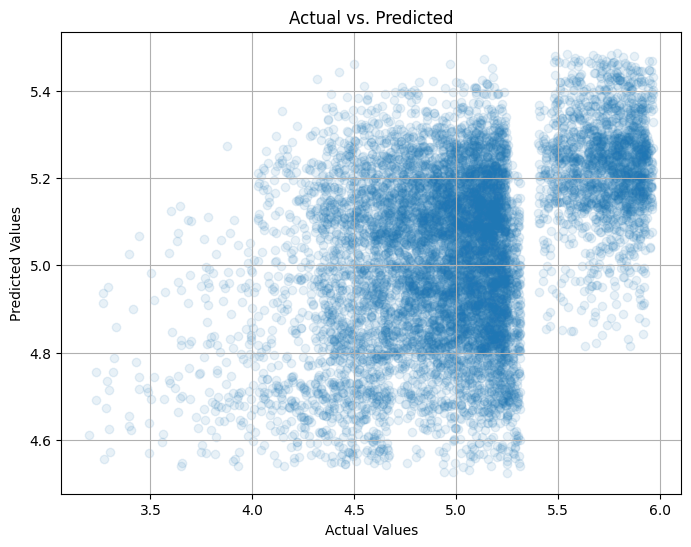

Mean Absolute Error: 0.3315143336888023
Mean Squared Error: 0.17244243128847644


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']

X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("PCA:")
n_components = 2
pca = PCA(n_components=n_components)
X_train_poly = pca.fit_transform(X_train_scaled)
X_test_poly = pca.transform(X_test_scaled)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_poly, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_poly)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Feature Implementation 3: Power Transformer

2 Most Important Features:
Private Attorney: 0.09883247054163427
Severity: 0.08155659538077188


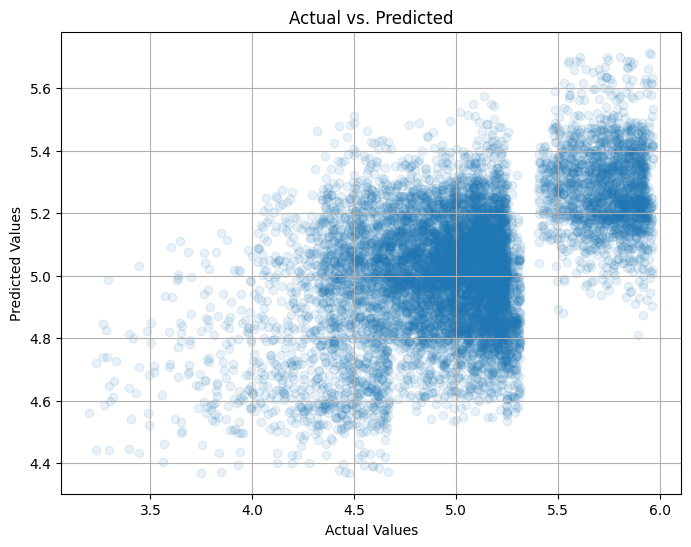

Test Results:
Mean Absolute Error (Test): 0.31130567658065766
Mean Squared Error (Test): 0.15402446509366097


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

pt = PowerTransformer()
X_train_power = pt.fit_transform(X_train)
X_test_power = pt.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_power)
X_test_scaled = scaler.transform(X_test_power)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

Feature Implementation 4: Outlier Trimming

2 Most Important Features:
Severity: 0.03444666196467667
OBGYN: 0.02728794274630418


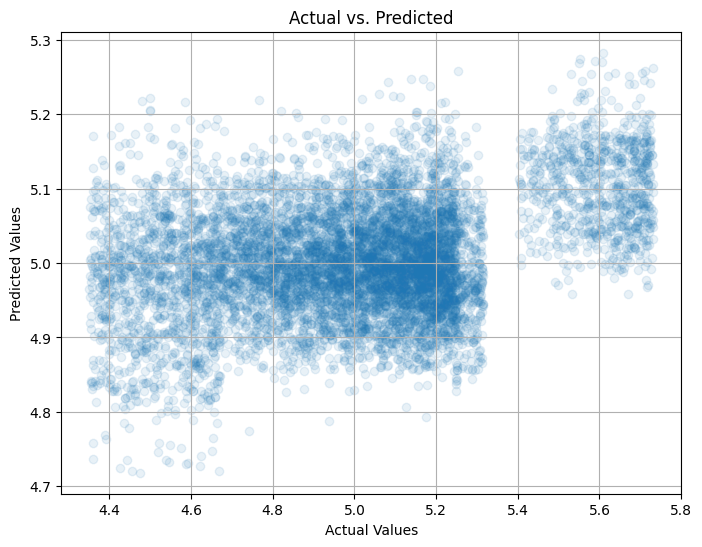

Test Results:
Mean Absolute Error (Test): 0.23635460234748418
Mean Squared Error (Test): 0.0859933958910552


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1.5, variables=['log_Amount'])
ot.fit(df_train)
df_train = ot.transform(df_train)
df_test = ot.transform(df_test)

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel ("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

Feature Implementation 5: t-SNE

2 Most Important Features:
Age: -0.0028817581478506327
Severity: -0.0006196059985086322


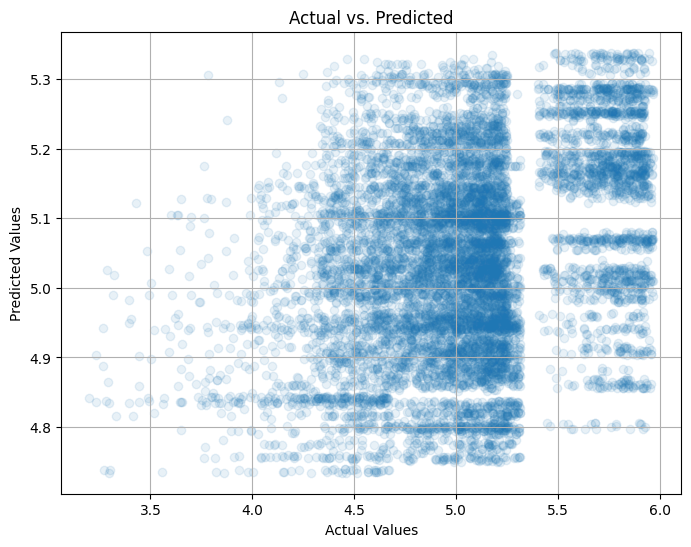

Test Results:
Mean Absolute Error (Test): 0.3419457507406272
Mean Squared Error (Test): 0.19071807429800555


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 2
tsne = TSNE(n_components=n_components, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_tsne, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

# K-Nearest Neighbors Regression


Import libraries and read in testing and training data

In [ ]:
import pandas as pd
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from sklearn.random_projection import GaussianRandomProjection
from feature_engine.outliers import OutlierTrimmer
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score # used to evaluate the quality of model for comparison purposes
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

Create train and test sets

In [ ]:
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

Standardize training and test data

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)

Find best K using grid search


In [ ]:
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

Fit K nearest neighbors

In [ ]:
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

Calculate mae, rmse, T-Stat, P-Val

Mean Absolute Error:  0.2547805812220973
Root Mean Squared Error:  0.32952938239974544
T-Statistic:  -1.013743600773849
P-Value:  0.31071757500581204


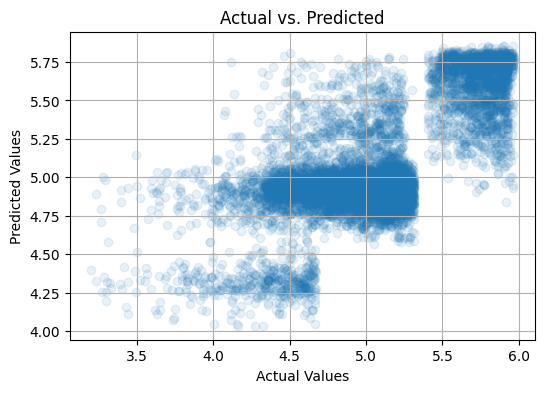

In [ ]:
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

### Feature implementations

Power Transformer

Power Transformer
Mean Absolute Error:  0.25565577042193066
Root Mean Squared Error:  0.3304699206296928
T-Statistic:  -1.028832543134861
P-Value:  0.30357101448505036


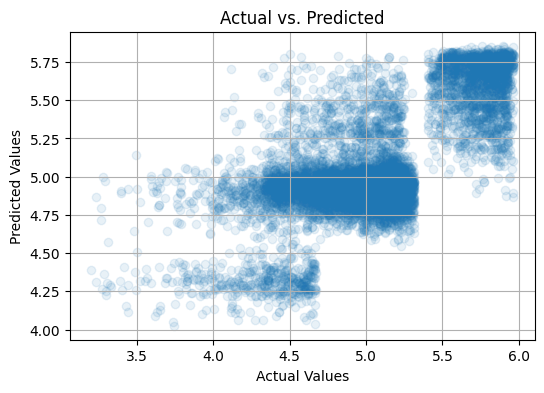

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

pt = PowerTransformer()
df_train_new = pt.fit_transform(df_train)
df_test_new = pt.transform(df_test)

#Create train and test sets for power transformer
X_train = pd.DataFrame(df_train_new, columns=df_train.columns).drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = pd.DataFrame(df_test_new, columns=df_test.columns).drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Power Transformer")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Outlier Trimmer


Outlier Trimmer
Mean Absolute Error:  0.21040359691782393
Root Mean Squared Error:  0.26145562749035195
T-Statistic:  -1.5147572503819158
P-Value:  0.12985321846184855


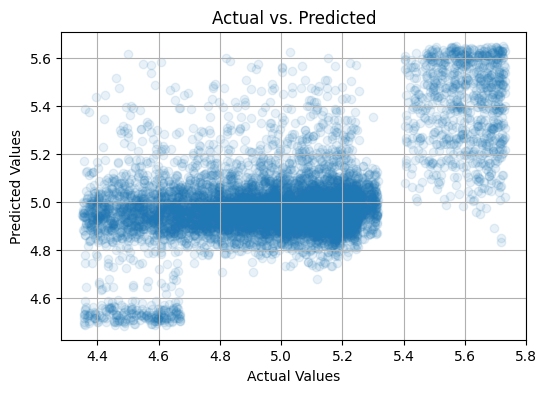

In [ ]:

df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1.5, variables=['log_Amount'])
ot.fit(df_train)
df_train = ot.transform(df_train)
df_test = ot.transform(df_test)

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Outlier Trimmer")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()


PCA

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)


pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("PCA")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


PCA
Mean Absolute Error:  0.29291348385204913
Root Mean Squared Error:  0.37742383912344424
T-Statistic:  -0.3561228266800322
P-Value:  0.7217524001859463


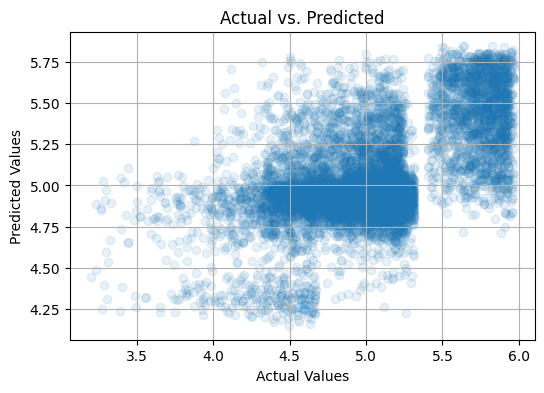

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Factor Analysis


In [ ]:

df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)


#Factor Analysis
fa = FactorAnalyzer()
fa.fit(X_train)
ev, v = fa.get_eigenvalues()
count = (ev > 1).sum()

fa = FactorAnalyzer(n_factors=count)
fa.fit(X_train)
X_train = fa.transform(X_train)
X_test = fa.transform(X_test)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Factor Analysis")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)



Factor Analysis
Mean Absolute Error:  0.3785143256377194
Root Mean Squared Error:  0.48683898832227557
T-Statistic:  33.38083505645901
P-Value:  1.0675832815475403e-237


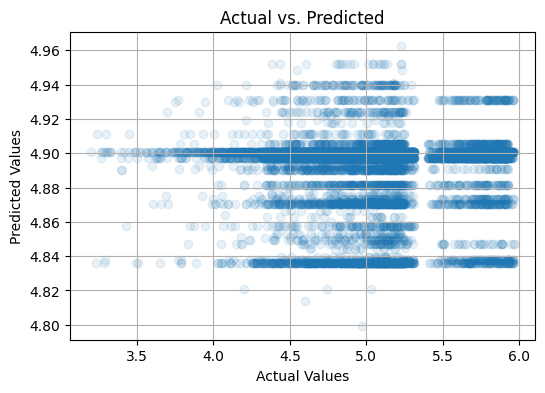

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Random Projection

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)


#Random Projection
rp = GaussianRandomProjection(n_components=24,random_state=42)
rp.fit(X_train)
X_train = rp.transform(X_train)
X_test = rp.transform(X_test)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Random Projection")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

Random Projection
Mean Absolute Error:  0.25442527748055843
Root Mean Squared Error:  0.32931206259539897
T-Statistic:  -1.2082546061461863
P-Value:  0.2269638600560752


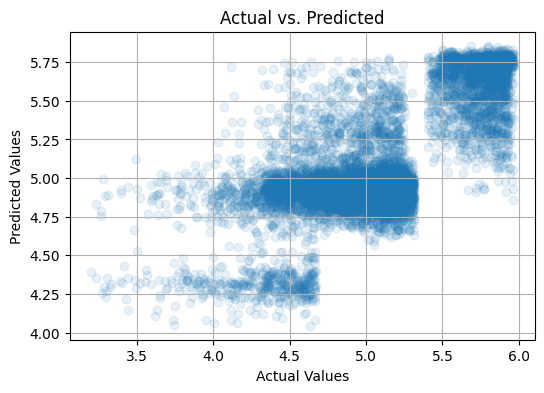

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()